In [2]:
import matplotlib.pyplot as plt
import pickle
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']
# })
#rc('text', usetex=True)

In [2]:
file='logs2022-05-14_11:36:01'
with open('out/'+file+'.pkl','rb') as savefile:
    save = pickle.load(savefile)

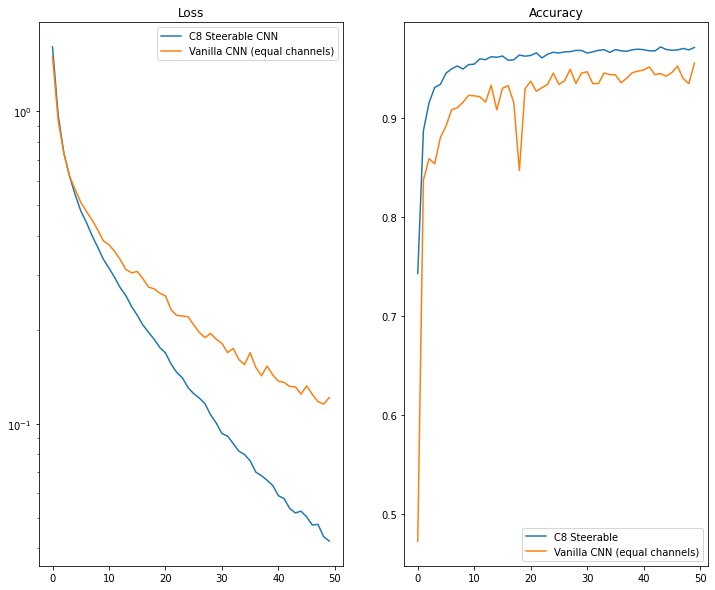

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
ax1.plot(save['steerable']['train']['loss'], label='C8 Steerable CNN')
ax1.plot(save['unsteerable']['train']['loss'], label='Vanilla CNN (equal channels)')
ax1.legend()
ax1.set_title('Loss')
ax1.set_yscale('log')
ax2.plot(save['steerable']['validation']['accuracy'], label='C8 Steerable')
ax2.plot(save['unsteerable']['validation']['accuracy'], label='Vanilla CNN (equal channels)')
ax2.legend()
ax2.set_title('Accuracy')
plt.show()
#plt.savefig('out/'+file+'.png')

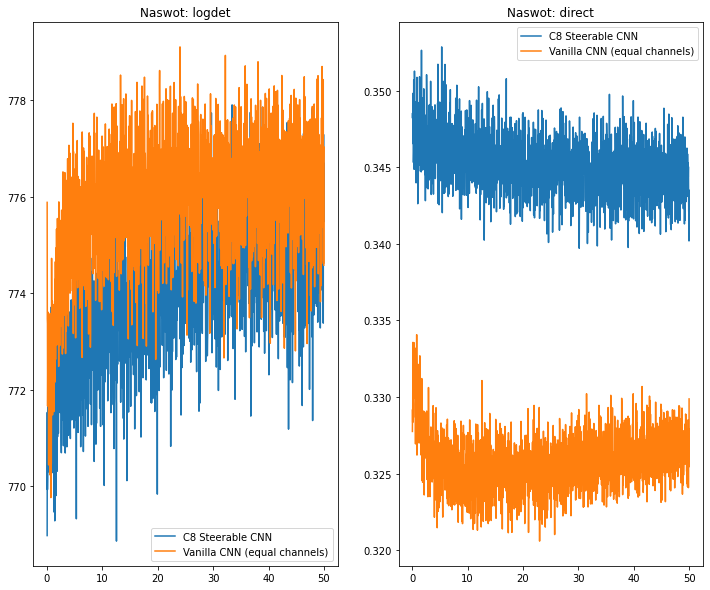

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
flatbatch = [item for sublist in save['steerable']['train']['batch'] for item in sublist]
if not max(flatbatch) > 1.0:
    epoch = 0
    for (i, batch) in enumerate(flatbatch):
        flatbatch[i] += epoch
        if batch == 1.0:
            epoch += 1
indices = [i+1 for i in range(len(flatbatch)-1) if flatbatch[i+1]-flatbatch[i] > 0.02]
ax1.plot([flatbatch[i] for i in indices], [save['steerable']['train']["naswot_ld"][i] for i in indices], label='C8 Steerable CNN')
ax1.plot([flatbatch[i] for i in indices], [save['unsteerable']['train']["naswot_ld"][i] for i in indices], label='Vanilla CNN (equal channels)')
ax1.legend()
ax1.set_title('NASWOT: logdet')
ax2.plot(flatbatch, save['steerable']['train']["naswot_rs"], label='C8 Steerable CNN')
ax2.plot(flatbatch, save['unsteerable']['train']["naswot_rs"], label='Vanilla CNN (equal channels)')
ax2.legend()
ax2.set_title('NASWOT: direct')
plt.show()
#plt.savefig('out/'+file+'testbatch.png')

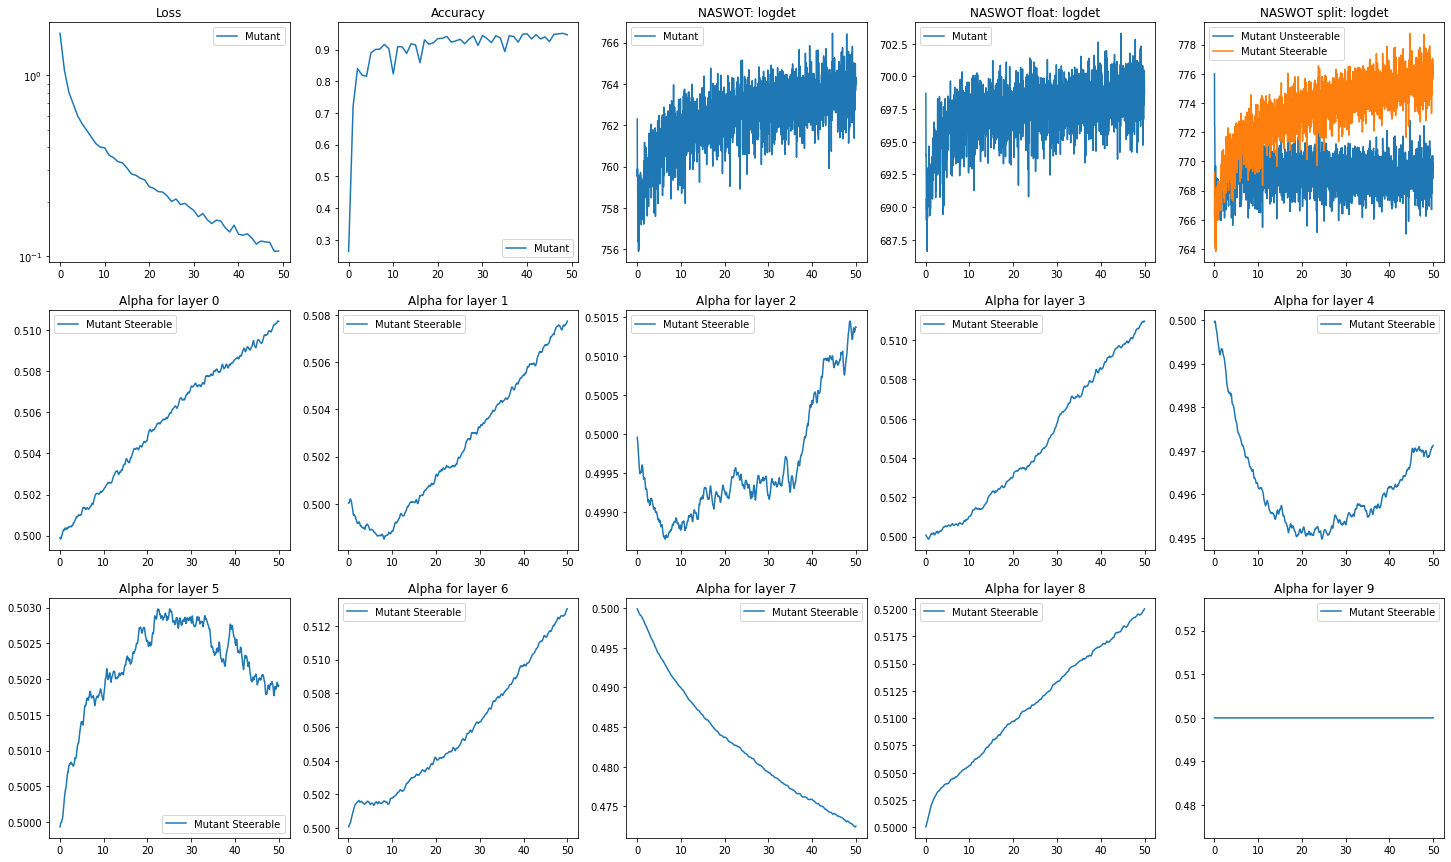

In [4]:
file='logsmutant2022-05-17_15:11:29'
with open('out/'+file+'.pkl','rb') as savefile:
    logs_mutant = pickle.load(savefile)
logs_mutant = logs_mutant["mutant"]
fig, ax = plt.subplots(3, 5, figsize=(25,15))
flatbatch = [item for sublist in logs_mutant['train']['batch'] for item in sublist]
if not max(flatbatch) > 1.0:
    epoch = 0
    for (i, batch) in enumerate(flatbatch):
        flatbatch[i] += epoch
        if batch == 1.0:
            epoch += 1
indices = [i+1 for i in range(len(flatbatch)-1) if flatbatch[i+1]-flatbatch[i] > 0.02]
ax[0,0].plot(logs_mutant['train']['loss'], label='Mutant')
ax[0,0].legend()
ax[0,0].set_title('Loss')
ax[0,0].set_yscale('log')
ax[0,1].plot(logs_mutant['validation']['accuracy'], label='Mutant')
ax[0,1].legend()
ax[0,1].set_title('Accuracy')
ax[0,2].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ld"][i] for i in indices], label='Mutant')
ax[0,2].legend()
ax[0,2].set_title('NASWOT: logdet')
ax[0,3].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ldF"][i] for i in indices], label='Mutant')
ax[0,3].legend()
ax[0,3].set_title('NASWOT float: logdet')
ax[0,4].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ldU"][i] for i in indices], label='Mutant Unsteerable')
ax[0,4].plot([flatbatch[i] for i in indices], [logs_mutant['train']["naswot_ldS"][i] for i in indices], label='Mutant Steerable')
ax[0,4].legend()
ax[0,4].set_title('NASWOT split: logdet')
for l in range(10):
    ax[int(l/5)+1,l%5].plot([flatbatch[i] for i in indices], [logs_mutant['train']["alphas"][l][i] for i in indices], label='Mutant Steerable')
    ax[int(l/5)+1,l%5].legend()
    ax[int(l/5)+1,l%5].set_title('Alpha for layer '+str(l))


In [3]:
def plothillclimb(file, alphasensitivity = 0.85):
    with open('out/'+file+'.pkl','rb') as savefile:
        save = pickle.load(savefile)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
    accs = [log['validation']['accuracy'][-1] for log in save.values()]
    maxacc = max(accs)
    minacc = min(accs)
    epochsteps = [log['epochsteps'][-1] for log in save.values()]
    print(minacc, maxacc)
    ax1.set_yscale('log')
    for uuid, log in sorted(save.items(), key=lambda x: x[1]['validation']['accuracy'][-1], reverse=True):
        if len(log['epochsteps']) > 5 and log['epochsteps'][0] == log['epochsteps'][5]:
            for i in range(5):
                log['epochsteps'][i] -= 1
            for i in range(190):
                log['trainsteps'][i] -= 1
        alpha = ((log['validation']['accuracy'][-1]-minacc)/(maxacc-minacc))**5
        if alpha > alphasensitivity and log['epochsteps'][-1] > max(epochsteps)*0.9:
            if type(log["ghistory"][-1][-1]) is tuple:
                label = str(log["ghistory"][-1])+" - "+str(log['validation']['accuracy'][-1])[:6]
            else:
                label = str(log["ghistory"][-6:])+" - "+str(log['validation']['accuracy'][-1])[:6]
            label = label.replace('(0, 0)', '$C_1$')
            label = label.replace('(0, 1)', '$C_2$')
            label = label.replace('(0, 2)', '$C_4$')
            label = label.replace('(0, 3)', '$C_8$')
        else:
            label = None
        if alpha > 0.0:
            ax1.plot(log['trainsteps'], log['train']['batchloss'], alpha=alpha, linewidth = alpha)
            ax2.plot(log['epochsteps'], log['validation']['accuracy'], alpha=alpha, linewidth = alpha)
            ax3.plot(log['epochsteps'], log['validation']['accuracy'], alpha=alpha, label=label)
    ax3.set_ylim(0.8*maxacc, 1.05*maxacc)
    ax3.legend(loc='upper left')
    ax1.set_title('Training loss')
    ax2.set_title('Validation accuracy')
    ax3.set_title('Validation accuracy (zoomed in)')
    ax1.set_xlabel('Iterations')
    ax2.set_xlabel('Iterations')
    ax3.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax3.set_ylabel('Accuracy')

    plt.savefig('out/'+file+'.png')


0.7286458611488342 0.9628125429153442


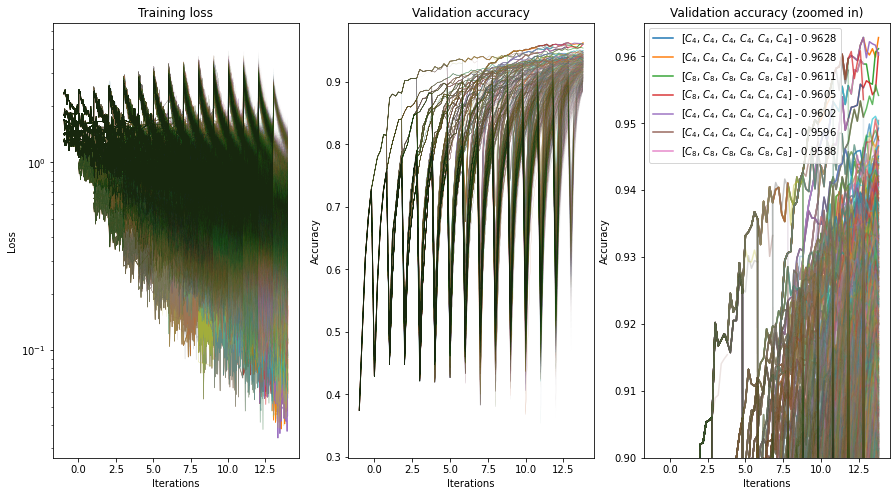

In [14]:
plothillclimb('logshc_2022-05-30_17:40:26')


0.36239585280418396 0.5695833563804626


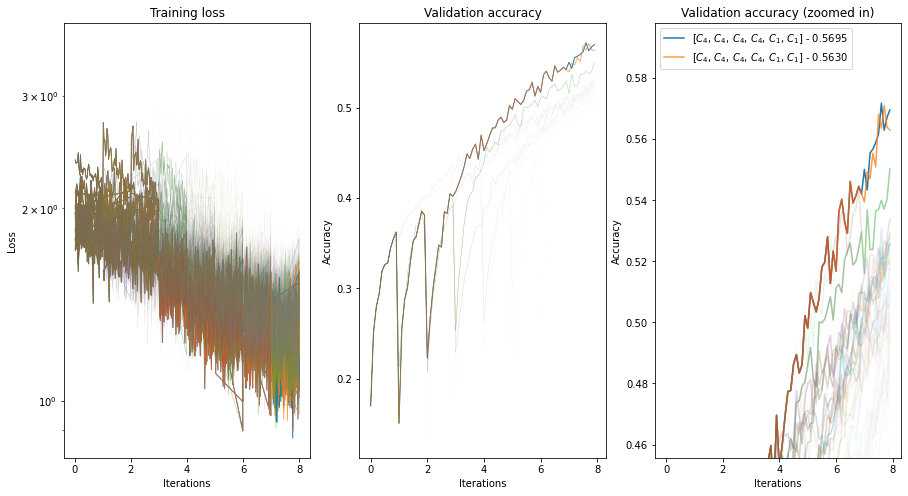

In [53]:
plothillclimb('logshc_2022-06-10_10:21:03', 0.5)


0.4229166805744171 0.7708333730697632


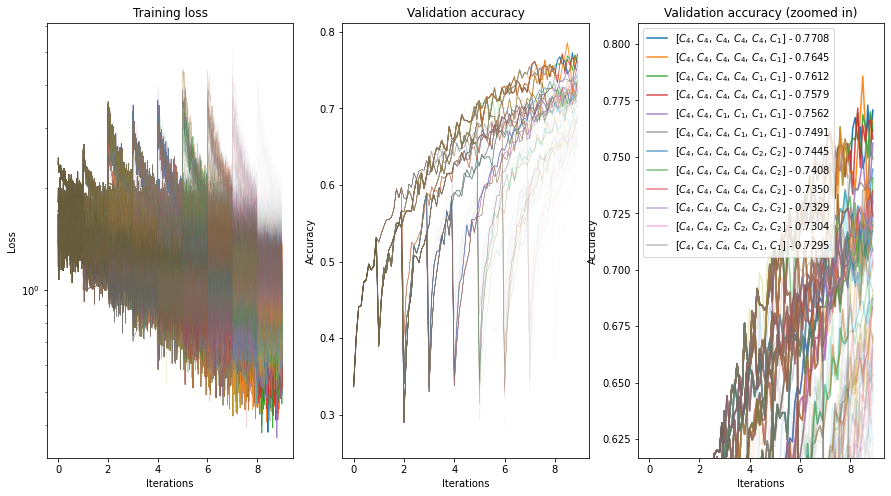

In [7]:
plothillclimb('logshc_2022-06-14_10:44:41', 0.5)


0.35614582896232605 0.6394791603088379


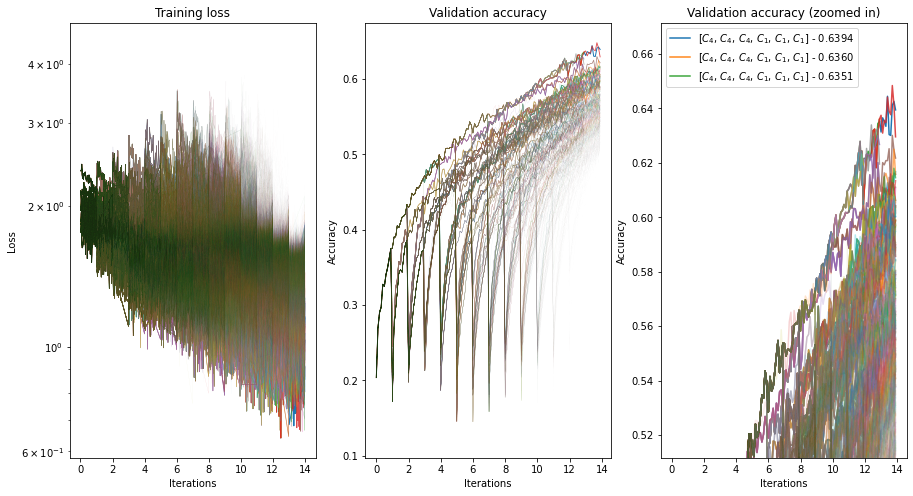

In [6]:
plothillclimb('logshc_2022-06-10_13:49:35', 0.9)
